In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import animation
from scipy import stats

import sys; 
sys.path.insert(1, '/saturn/simu_Caribbean/coupled_2km')
sys.path.append('/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from pdist_fb_distrib_save_fast import *
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_nobnd_EU.npy')

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan
    
# tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
# open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [5]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
sst_day = sst.groupby('time_counter.day').mean()

In [6]:
T2 = ds_hourly['T2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
T2_day = T2.groupby('time_counter.day').mean()

q2 = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
q2_day = q2.groupby('time_counter.day').mean()


PBLH_day = ds_hourly['PBLH'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
PBLH_day = PBLH_day.groupby('time_counter.day').mean()


In [7]:
U = ds_hourly['U_PHYL1'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()
V = ds_hourly['V_PHYL1'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000')).groupby('time_counter.day').mean()

# ws = (U_day**2 + V_day**2)**0.5
# del U_day, V_day

# ws_day = ws.groupby('time_counter.day').mean()

In [8]:
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

In [9]:
s = 75
sigma_sub = 0

dsst = np.zeros(sst_day.shape)
sst_day_ave = np.zeros(sst_day.shape)

dT2 = np.zeros(sst_day.shape)
t2_day_ave = np.zeros(sst_day.shape)

dq2  = np.zeros(sst_day.shape)
q2_day_ave = np.zeros(sst_day.shape)

dPBLH = np.zeros(sst_day.shape)
PBLH_day_ave = np.zeros(sst_day.shape)


for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_day_ave[t] = gm.nan_gaussian_filter(sst_day[t].values*sea_mask_modified_nan,s)          
    dsst[t] = sst_day[t] - sst_day_ave[t]
    dsst[t] = gm.nan_gaussian_filter(dsst[t]*sea_mask_modified_nan, sigma_sub)
    
    q2_day_ave[t] = gm.nan_gaussian_filter(q2_day[t].values*sea_mask_modified_nan, s)          
    dq2[t] = q2_day[t] - q2_day_ave[t]
    dq2[t] = gm.nan_gaussian_filter(dq2[t]*sea_mask_modified_nan, sigma_sub)
    
    t2_day_ave[t] = gm.nan_gaussian_filter(T2_day[t].values*sea_mask_modified_nan, s)          
    dT2[t] = T2_day[t] - t2_day_ave[t]
    dT2[t] = gm.nan_gaussian_filter(dT2[t]*sea_mask_modified_nan, sigma_sub)
    
    PBLH_day_ave[t] = gm.nan_gaussian_filter(PBLH_day[t].values*sea_mask_modified_nan, s)        
    dPBLH[t] = PBLH_day[t].values*sea_mask_modified_nan - PBLH_day_ave[t]
    dPBLH[t] = gm.nan_gaussian_filter(dPBLH[t]*sea_mask_modified_nan, sigma_sub)

0
10
20


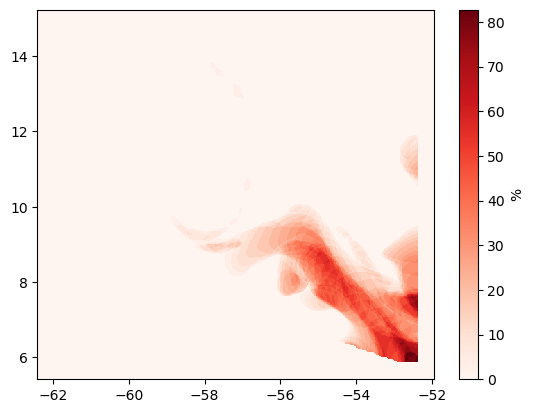

In [10]:
warm_sst = np.where(dsst>0.22, 1., 0.)
warm_sst = 100*np.sum(warm_sst, axis=0)/29 

plt.pcolormesh(lon, lat, warm_sst, cmap='Reds')
plt.colorbar(label='%')

In [32]:
type(U)

xarray.core.dataarray.DataArray

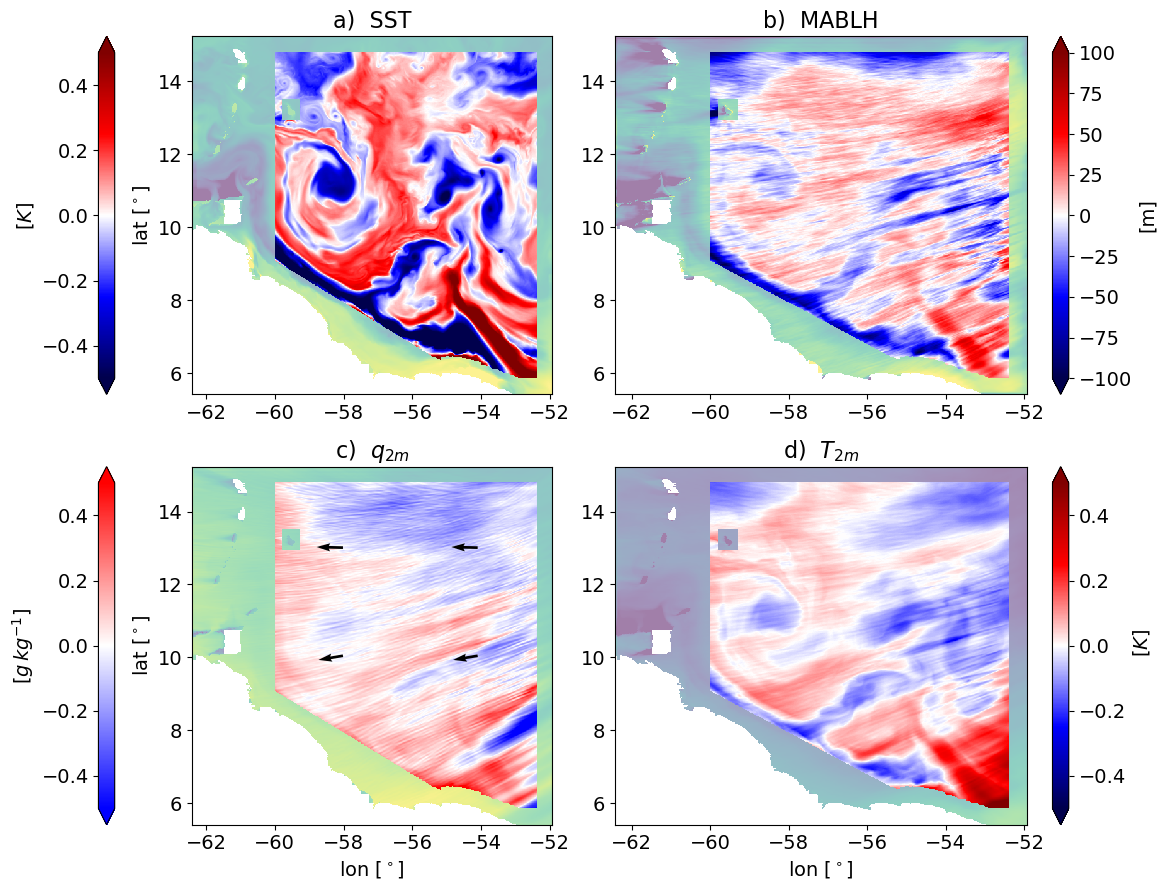

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
# plt.suptitle('200km anomalies, 11th Feb.', fontsize=16)
day = int(0)

mask_here = np.where(sst_day[day]/sst_day[day] != 1, np.nan, 1)

#######################################################
ax[0,0].pcolormesh(lon, lat, sst_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301) #, cmap='coolwarm')
sst_map = ax[0,0].pcolormesh(lon, lat, dsst[day]*sea_mask_modified_nan, vmin=-0.5, vmax=0.5, cmap='seismic')

cbar1 = plt.colorbar(sst_map, ax=ax[0,0], label=r'SST anoms [K]', extend='both', location='left', pad=0.15)
cbar1.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar1.set_label(r'[$K$]', fontsize=14)  # Set fontsize for colorbar label
# ax[0,0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[0,0].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[0,0].set_title("a)  SST", fontsize=16)


#######################################################



ax[0,1].pcolormesh(lon, lat, PBLH_day[day]*mask_here, alpha=0.5, vmin=500, vmax=800) #, cmap='coolwarm')
pblh_map = ax[0,1].pcolormesh(lon, lat, dPBLH[day]*sea_mask_modified_nan, vmin=-100, vmax=100, cmap='seismic')

cbar1 = plt.colorbar(pblh_map, ax=ax[0,1], extend='both', location='right') #, pad=0.15)
cbar1.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar1.set_label(r'[m]', fontsize=14)  # Set fontsize for colorbar label
# ax[0,1].set_xlabel('lon [$^\circ$]', fontsize=14)
# ax[0,1].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[0,1].set_title("b)  MABLH", fontsize=16)


###############################################
ax[1,0].pcolormesh(lon, lat, q2_day[day]*mask_here*1e3, alpha=0.5)
q2_map = ax[1,0].pcolormesh(lon, lat, dq2[day]*1e3*sea_mask_modified_nan, vmin=-0.5, vmax=0.5, cmap='bwr')

lons_quiv = [-58.018097, -54.095005]
lats_quiv = [10.04686, 13.010284]
lon_inds = [np.where(lon == l)[0][0] for l in lons_quiv]
lat_inds = [np.where(lat == l)[0][0] for l in lats_quiv]

U_q = U.isel(day=day, y=lat_inds, x=lon_inds)
V_q = V.isel(day=day, y=lat_inds, x=lon_inds)

llons_q, llats_q = np.meshgrid(lons_quiv, lats_quiv)

q2_quiver = ax[1,0].quiver(llons_q, llats_q, U_q, V_q, scale=120)

cbar3 = plt.colorbar(q2_map, ax=ax[1,0], label=r'', location='left', extend='both', pad=0.15)
cbar3.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar3.set_label(r"[$g\,kg^{-1}$]", fontsize=14)  # Set fontsize for colorbar label
ax[1,0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[1,0].set_ylabel('lat [$^\circ$]', fontsize=14)
ax[1,0].set_title(r"c)  $q_{2m}$", fontsize=16)



########################à

ax[1,1].pcolormesh(lon, lat, T2_day[day]*mask_here, alpha=0.5, vmin=298, vmax=301)
t2_map = ax[1,1].pcolormesh(lon, lat, dT2[day]*sea_mask_modified_nan, vmin=-0.5, vmax=0.5, cmap='seismic')
cbar2 = plt.colorbar(t2_map, ax=ax[1,1], label=r'T2 anoms [$K}$]', extend='both', location='right') #, pad=0.15)
cbar2.ax.tick_params(labelsize=14)  # Set fontsize for colorbar ticks
cbar2.set_label(r' [$K$]', fontsize=14)  # Set fontsize for colorbar label
ax[1,1].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[1,1].set_title(r"d)  $T_{2m}$", fontsize=16)

# Set fontsize for tick labels
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()


plt.savefig('/venus/tesi_ale/img_EU/plots_MeteoXChange/maps_EMS_revisions.png')


### EMS plots

In [5]:
data_loc = '/venus/tesi_ale/EMS_revisions/EMS-tidy-codes/'

ds_MABLH = xr.open_dataset(data_loc+'pdistrs_dMABLHpr.nc')
ds_dN2   = xr.open_dataset(data_loc+'pdistrs_dN2.nc')
ds_dQVAPOR = xr.open_dataset(data_loc+'pdistrs_dQVAPOR.nc')
ds_dT = xr.open_dataset(data_loc+'pdistrs_dT.nc')
ds_SST_LHF = xr.open_dataset(data_loc+'LHF_SST_anomalies_fig2d.nc')

In [6]:
mean_vert_pres = ds_dN2['mean_vert_pres'].values  #np.load('/venus/tesi_ale/dati_proceedings_EMS/EMS-tidy-codes/mean_vert_pres.npy')

In [7]:
# figure dBV or BV vs dSST bin - DAILY

def local_vertical_plot(ax, pdist_sst, pdist_var, mean_vert_pres, pdist_mabl, pvalue, extrema):

    p_level_plot = int(15)


    x = pdist_sst   
    var = pdist_var[0:p_level_plot,:]    
    
    ax.invert_yaxis()
    p1 = ax.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=extrema[0], vmax=extrema[1], cmap='seismic')
    
    x_pbl = x                         
    var_pbl = pdist_mabl    
    ax.plot(x_pbl, var_pbl, 'k', linewidth=2.5, label="MABLH'")
    ax.legend(fontsize=14, loc='upper left')


    ax.tick_params(axis='x', labelsize=14) 
    ax.tick_params(axis='y', labelsize=14)


    # DEF punti significativi (pvalue < 0.05)
    pval = pvalue[0:p_level_plot] 
    GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
    signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
    for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
        cond1 = pval[h,:-1] > 0.05
        cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
        cond = (cond1) | (cond2)
    #     cond = cond1
        signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
        signif_Lcorr_H[h, cond] = GPbin[h]
        dsstbin[h,:] = x[1:] - np.diff(x)*0.5

    ax.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')

    return p1
    

In [9]:
ds_MABLH

<xarray.Dataset>
Dimensions:            (dsst: 20)
Dimensions without coordinates: dsst
Data variables:
    pdist_dsst         (dsst) float64 ...
    pdist_dMABLHpr     (dsst) float64 ...
    pstd_dMABLHpr      (dsst) float64 ...
    pstderr_dMABLHpr   (dsst) float64 ...
    pnpoints_dMABLHpr  (dsst) float64 ...
    mean_MABLH         (dsst) float64 ...

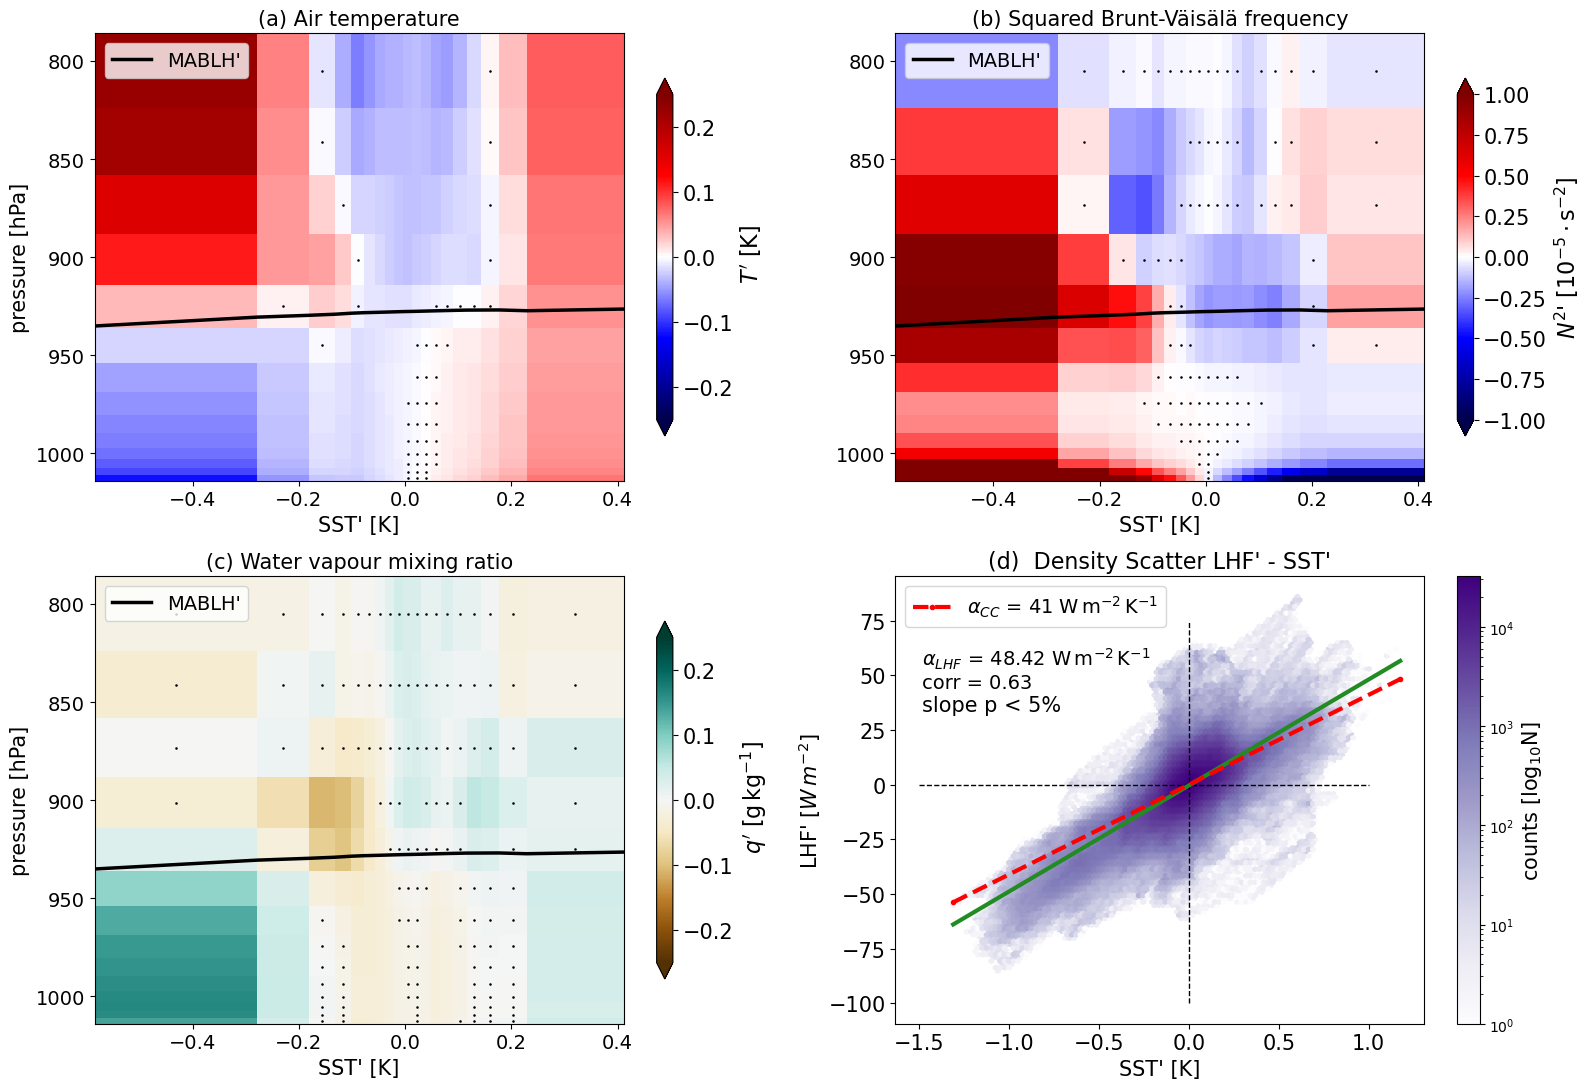

In [9]:

fig, ax = plt.subplots(2,2,figsize=(16,11))

################ temperature
p1 = local_vertical_plot(ax[0,0], ds_dT['pdist_dsst'].values, ds_dT['pdist_dT'].values, mean_vert_pres, ds_MABLH['pdist_dMABLHpr'].values + ds_MABLH['mean_MABLH'].values, ds_dT['ppvalue_dT_sub'].values, [-0.25,0.25])
ax[0,0].set_xlabel("SST' [K]", fontsize=15)
ax[0,0].set_ylabel('pressure [hPa]', fontsize=15)
ax[0,0].set_title(f"(a) Air temperature", fontsize=15)
cbar = plt.colorbar(p1,ax=ax[0,0], location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r" $T'$ [K]", fontsize=16)
cbar.ax.tick_params(labelsize=15)


# ############### stability
# p1 = local_vertical_plot(ax[0,1], ds_dN2['pdist_dsst'].values, ds_dN2['pdist_dN2'].values*1e5, mean_vert_pres, ds_MABLH['pdist_MABLH_day'].values, ds_dN2['ppvalue_dN2_sub'].values, [-1.,1.])
# ax[0,1].set_xlabel('SST' [K]', fontsize=15)
# # ax[0,1].set_ylabel('pressure [hPa]', fontsize=14)
# ax[0,1].set_title(f"(b)  $N^2$' vs SST'", fontsize=15)
# cbar = plt.colorbar(p1,ax=ax[0,1], location='right', shrink=0.8, extend='both', pad=0.05)  
# cbar.set_label("$N^2$'' [$10^{-5} \cdot s^{-2}$]", fontsize=16)
# cbar.ax.tick_params(labelsize=15)


# Plot the main image
p1 = local_vertical_plot(
    ax[0,1], 
    ds_dN2['pdist_dsst'].values, 
    ds_dN2['pdist_dN2'].values * 1e5, 
    mean_vert_pres, 
    ds_MABLH['pdist_dMABLHpr'].values + ds_MABLH['mean_MABLH'].values, 
    ds_dN2['ppvalue_dN2_sub'].values, 
    [-1., 1.]
)

# # Define mean, lower and upper bounds for the shaded MABL region
# sst_vals = ds_dN2['pdist_dsst'].values
# mabl_mean = ds_MABLH['pdist_MABLH_day'].values
# mabl_std = ds_MABLH['pstd_MABLH_day'].values
# mabl_upper = mabl_mean + mabl_std
# mabl_lower = mabl_mean - mabl_std

# # Plot the shaded region
# ax[0,1].fill_between(
#     sst_vals, 
#     mabl_lower, 
#     mabl_upper, 
#     color='black', 
#     alpha=0.3, 
#     label='MABL ±1 std'
# )

# Axis and colorbar formatting
ax[0,1].set_xlabel("SST' [K]", fontsize=15)
# ax[0,1].set_ylabel('pressure [hPa]', fontsize=14)
ax[0,1].set_title("(b) Squared Brunt-Väisälä frequency", fontsize=15)


# Colorbar
cbar = plt.colorbar(p1, ax=ax[0,1], location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r"$N^2$' [$ \rm 10^{-5} \cdot s^{-2}$]", fontsize=16)
cbar.ax.tick_params(labelsize=15)
# # Plot the main image
# p1 = local_vertical_plot(
#     ax[0,1], 
#     ds_dN2['pdist_dsst'].values, 
#     ds_dN2['pdist_dN2'].values * 1e5, 
#     mean_vert_pres, 
#     ds_MABLH['pdist_dMABLHpr'].values + ds_MABLH['mean_MABLH'].values, 
#     ds_dN2['ppvalue_dN2_sub'].values, 
#     [-1., 1.]
# )

# # Overlay error bars for MABL height
# # ax[0,1].errorbar(
# #     ds_dN2['pdist_dsst'].values,  # X: SST anomalies
# #     ds_MABLH['pdist_MABLH_day'].values,  # Y: MABL mean pressure
# #     yerr=ds_MABLH['pstd_MABLH_day'].values,  # Vertical error
# #     fmt='o', 
# #     color='black', 
# #     ecolor='black', 
# #     capsize=3, 
# #     label='MABL ± 1 std'
# # )

# # Axis and colorbar formatting
# ax[0,1].set_xlabel('SST' [K]', fontsize=15)
# # ax[0,1].set_ylabel('pressure [hPa]', fontsize=14)
# ax[0,1].set_title(f"(b)  $N^2$' vs SST'", fontsize=15)

# # Colorbar
# cbar = plt.colorbar(p1, ax=ax[0,1], location='right', shrink=0.8, extend='both', pad=0.05)  
# cbar.set_label("$N^2$'' [$10^{-5} \cdot s^{-2}$]", fontsize=16)
# # cbar.ax.tick_para_








##################################à qvapor
p1 = local_vertical_plot(ax[1,0], ds_dQVAPOR['pdist_dsst'].values, ds_dQVAPOR['pdist_dQVAPOR'].values*1e3,\
                         mean_vert_pres, ds_MABLH['pdist_dMABLHpr'].values + ds_MABLH['mean_MABLH'].values, ds_dQVAPOR['ppvalue_dQVAPOR_sub'].values, [-0.25,0.25])
p1.set_cmap('BrBG')
ax[1,0].set_xlabel("SST' [K]", fontsize=15)
ax[1,0].set_ylabel('pressure [hPa]', fontsize=15)
ax[1,0].set_title(f"(c) Water vapour mixing ratio", fontsize=15)
cbar = plt.colorbar(p1,ax=ax[1,0], location='right', shrink=0.8, extend='both', pad=0.05)  
cbar.set_label(r" $q'$ [$\rm g\,kg^{-1}$]", fontsize=16)
cbar.ax.tick_params(labelsize=15)








###  regression plot
from func_statistics import slopes_r_p_mix
from plotdistr import density_hexbin

x = ds_SST_LHF['dSST'].values
y = ds_SST_LHF['dLH'].values

nt = 1; nskip = 15

fit, corcoe, p_value, p_value_cannelli, sigmas_dsst_dlh = slopes_r_p_mix(x, y, nt, nskip)
title= "(d)  Density Scatter LHF' - SST'"
xlabel="SST' [K]"
ylabel= "LHF' [$W\,m^{-2}$]"
miny = -100 ; maxy = 75
minx = -1.5 ; maxx = 1
    
pos = [0.05, 0.8]
fig = density_hexbin(x,y, plot_fit=True,fit=fit,corcoe=corcoe,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='Purples', pos=pos, slope_units=r" $\rm W\,m^{-2}\,K^{-1}$")

plt.tick_params(axis='x', labelsize=15) 
plt.tick_params(axis='y', labelsize=15)



plt.vlines(0, ymin=miny, ymax=maxy, color='k', linewidth=1, linestyle='--')
plt.hlines(0, xmin=minx, xmax=maxx, color='k', linewidth=1, linestyle='--')
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p < 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=15, color='k')
else:
    plt.annotate('slope p > 5%', xy=(pos[0], pos[1]-0.1), \
                         xycoords='axes fraction', fontsize=15, color='k')

    
plt.plot([np.nanmin(x[~np.isnan(x)]), np.nanmax(x[~np.isnan(x)])],\
         np.array([np.nanmin(x[~np.isnan(x)]), np.nanmax(x[~np.isnan(x)])])*41.,\
         'r.--', linewidth=3, label=r"$\alpha_{CC}$ = 41 $\rm W\,m^{-2}\,K^{-1}$")
plt.legend(fontsize=14, loc='upper left')
#  np.nanpercentile(rho_air*1.3e-3*L_v*ws_10*1.28, 50)



plt.tight_layout()
filename = '/venus/tesi_ale/img_EU/allVertical_EMS_revisions.pdf'
# plt.savefig(filename)